# UGallery dataset

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

## Artworks data

In [2]:
artworks = pd.read_csv("valid_artworks.csv")
artworks.head()

,id,artist_id,upload_date,original,medium_id
0,32769,11208,2014-06-25 07:07:27.223,t,0
1,32771,15061,2014-06-25 11:05:29.413,t,12
2,38230,1169,2015-04-29 17:33:10.29,t,12
3,16391,9175,2011-09-12 19:46:44.093,f,12
4,49163,27661,2016-10-17 11:47:05.107,f,16


In [3]:
artworks["artwork_id"] = artworks["id"]

## Sales data

In [4]:
sales = pd.read_csv("valid_sales.csv")
sales.head()

,id,customer_id,artwork_id,order_date
0,2207,25133,21084,2015-02-16 21:12:53.993
1,4840,31652,40809,2016-03-13 11:30:24.777
2,266,18993,27421,2014-03-05 12:29:36.917
3,2124,21535,27596,2015-02-03 23:32:22.113
4,7253,8836,50963,2017-12-13 14:43:17.92


In [5]:
print("Sales shape", sales.shape)
print("Artworks shape", artworks.shape)

Sales shape (6535, 4)
Artworks shape (7742, 6)


There are 6535 rows in the sales file, but possibly less transactions, because a single transaction can include more than an item.

In [6]:
# Check if all arworks ids from sales exist in artworks
assert all(s in artworks["id"].values for s in sales["artwork_id"].values)

## Interactions data

In [7]:
data = pd.merge(sales[["customer_id", "artwork_id", "order_date"]], artworks[["artwork_id", "artist_id"]], on="artwork_id", how="left")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6535 entries, 0 to 6534
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6535 non-null   int64 
 1   artwork_id   6535 non-null   int64 
 2   order_date   6535 non-null   object
 3   artist_id    6535 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 255.3+ KB


No missing values in this dataframe. `order_date` is stored as an object, but could be stored as timestamp easily:

In [9]:
data["date"] = data["order_date"].apply(lambda t: int(datetime.strptime(t[:19], "%Y-%m-%d %H:%M:%S").timestamp()))

In [10]:
data.head()

,customer_id,artwork_id,order_date,artist_id,date
0,25133,21084,2015-02-16 21:12:53.993,9410,1424131973
1,31652,40809,2016-03-13 11:30:24.777,28202,1457879424
2,18993,27421,2014-03-05 12:29:36.917,14720,1394033376
3,21535,27596,2015-02-03 23:32:22.113,12776,1423017142
4,8836,50963,2017-12-13 14:43:17.92,19348,1513186997


In [11]:
data.describe()

,customer_id,artwork_id,artist_id,date
count,6535.000000,6535.000000,6535.000000,6.535000e+03
mean,27342.026473,39256.486305,16679.781025,1.457700e+09
std,9474.240096,12181.923937,9834.853123,4.011590e+07
min,269.000000,2383.000000,191.000000,1.388591e+09
25%,20779.000000,31010.500000,8603.000000,1.424074e+09
50%,27015.000000,39558.000000,15720.000000,1.452803e+09
75%,34595.000000,49615.500000,23919.000000,1.493595e+09
max,44627.000000,60160.000000,44220.000000,1.527820e+09


Sort sales data by timestamp.

In [12]:
data = data.sort_values(by="order_date", ascending=True)
data.head()

,customer_id,artwork_id,order_date,artist_id,date
433,18049,29199,2014-01-01 12:49:27.887,198,1388591367
5318,17840,28803,2014-01-02 14:11:15.163,15733,1388682675
3415,15173,21413,2014-01-02 21:58:46.343,12574,1388710726
246,18085,28801,2014-01-04 02:43:49.737,7636,1388814229
5864,12263,28536,2014-01-05 04:48:40.783,10986,1388908120


**How many orders are actually contained?** Considering items bought at the same time (by the same user) part of a single order:

In [13]:
len(data.groupby(["order_date", "customer_id"]))

4897

**What is the maximum number of items purchased in the same order?**

In [14]:
grouped_orders = data.groupby(["order_date", "customer_id"])["artwork_id"].apply(list).reset_index()
grouped_orders["n_items"] = grouped_orders["artwork_id"].apply(len)

In [15]:
grouped_orders["n_items"].max()

21

In [16]:
grouped_orders[grouped_orders["n_items"] == grouped_orders["n_items"].max()]["artwork_id"].values

array([list([31715, 34161, 33163, 34067, 26013, 36777, 26014, 33766, 23463, 18979, 32545, 19430, 37596, 29884, 32522, 26461, 37595, 32222, 36654, 34156, 19429])],
      dtype=object)

**Did any user buy the same item more than once?**

In [17]:
for customer_id, group in data.groupby(["customer_id"]):
    purchased_items = group["artwork_id"].values
    if len(purchased_items) != len(set(purchased_items)):
        print(f"Customer {customer_id} bought: {purchased_items}")


Customer 14580 bought: [24424 13251 24424 39701 41240 33222 40275 40808]
Customer 18402 bought: [21084 21084]
Customer 19628 bought: [17033 33416 10913 19203 27786 13248 32843 10816 26675 10816 28202 23130
 34493 28572 34495]
Customer 20691 bought: [32132 26223 32458 32132 21462 38569 40623 39076 40496]
Customer 25126 bought: [29901 36653 29901]
Customer 25450 bought: [10846 10625 10625]


**Number of interactions per user?**

In [18]:
users = data.groupby(["customer_id"]).count()["artwork_id"]
users.describe()

count    2919.000000
mean        2.238780
std         5.968692
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       271.000000
Name: artwork_id, dtype: float64

**Most active items?**

In [19]:
items = data.groupby(["artwork_id"]).count()["customer_id"]
items.describe()

count    6030.000000
mean        1.083748
std         0.523571
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: customer_id, dtype: float64

In [20]:
most_active_items = items.sort_values(ascending=False)
most_active_items.head()

artwork_id
24424    16
41937    11
31527    11
21198    10
13280     9
Name: customer_id, dtype: int64

In [21]:
N = 5
interactions_by_active_items = most_active_items[:N].sum() / items.sum() * 100
print(f"{interactions_by_active_items:.2f} % of interactions comes from the top {N} most active items")

0.87 % of interactions comes from the top 5 most active items


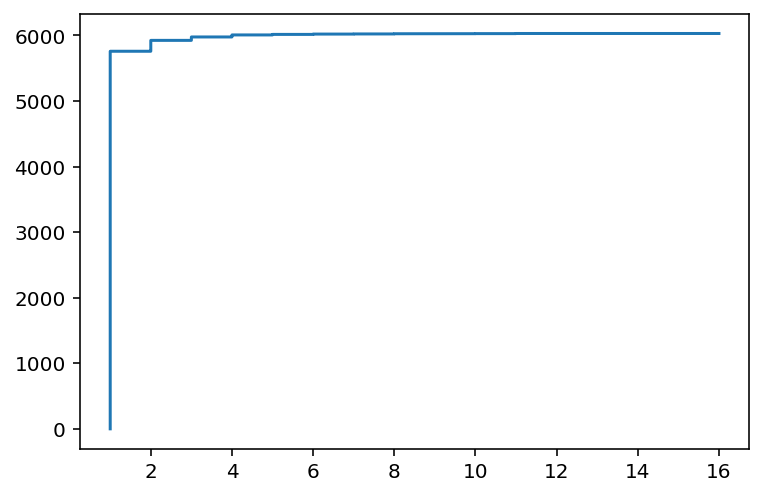

In [22]:
sorted_data = np.sort(most_active_items)
plt.step(sorted_data, np.arange(sorted_data.size))
plt.show()

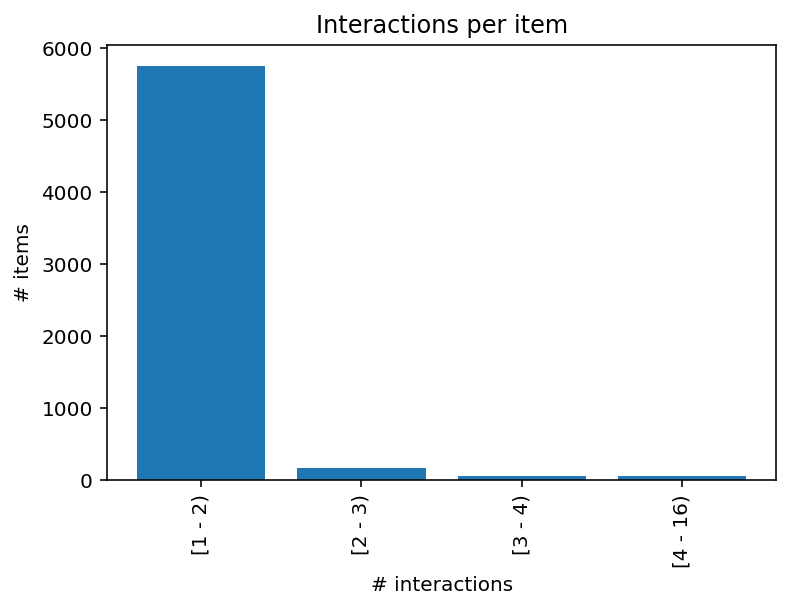

In [23]:
bins = list(range(1, 5)) + [items.max()]

hist, bins = np.histogram(items, bins)
x_axis = np.arange(0, len(hist))
plt.bar(x_axis, hist)
bin_names = [f"[{bins[i]} - {bins[i+1]})" for i in range(len(hist))]
plt.xticks(x_axis, bin_names, rotation=90)

# Title and labels
plt.title("Interactions per item")
plt.xlabel("# interactions")
plt.ylabel("# items")
plt.show()

**Most active users?**

In [24]:
most_active_users = users.sort_values(ascending=False)
most_active_users.head()

customer_id
39573    271
17426     62
27648     61
30020     51
23287     43
Name: artwork_id, dtype: int64

In [25]:
N = 5
interactions_by_active_users = most_active_users[:N].sum() / users.sum() * 100
print(f"{interactions_by_active_users:.2f} % of interactions comes from the top {N} most active users")

7.47 % of interactions comes from the top 5 most active users


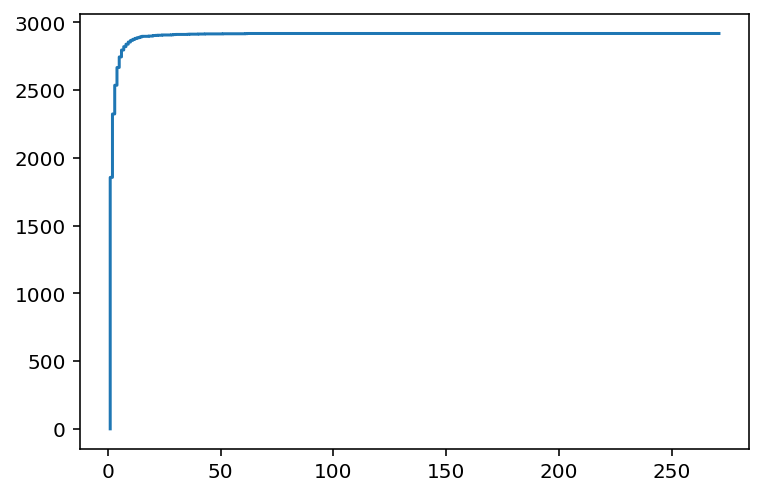

In [26]:
import numpy as np


sorted_data = np.sort(most_active_users)
plt.step(sorted_data, np.arange(sorted_data.size))
plt.show()

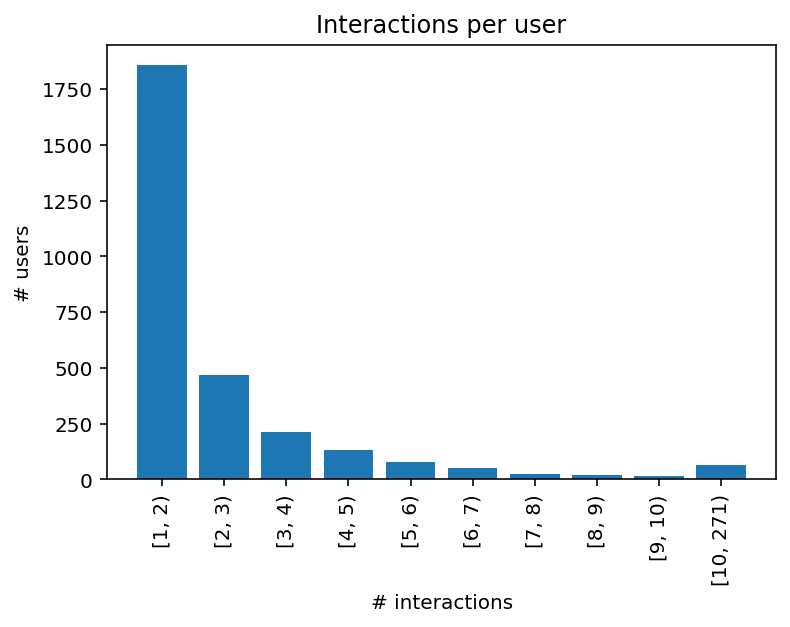

In [27]:
bins = list(range(1, 11)) + [users.max()]

hist, bins = np.histogram(users, bins)
x_axis = np.arange(0, len(hist))
plt.bar(x_axis, hist)
bin_names = [f"[{bins[i]}, {bins[i+1]})" for i in range(len(hist))]
plt.xticks(x_axis, bin_names, rotation=90)

# Title and labels
plt.title("Interactions per user")
plt.xlabel("# interactions")
plt.ylabel("# users")
plt.show()

## Output

In [28]:
n_users = data["customer_id"].nunique()
n_items = data["artwork_id"].nunique()
n_items_gt = 13297  
print(f"Unique users: {n_users}")
print(f"Unique items: {n_items_gt}")
print(f"Unique items 'interacted': {n_items}")
print(f"Interactions per user: {users.mean()} +/- {users.std()}")
actual_mean = items.sum() / n_items_gt
actual_std = np.sqrt(np.mean(np.abs(items - actual_mean)**2))
print(f"Interactions per item: {actual_mean} +/- {actual_std}") 
print(f"Interactions per 'interacted' item: {items.mean()} +/- {items.std()}")
possible_interactions = n_users * n_items_gt
print(f"Possible interactions: {possible_interactions}")
print(f"Sparsity: {100 * len(data) / possible_interactions:2f}%")

Unique users: 2919
Unique items: 13297
Unique items 'interacted': 6030
Interactions per user: 2.23878040424803 +/- 5.968691735577569
Interactions per item: 0.49146424005414757 +/- 0.7904940087948841
Interactions per 'interacted' item: 1.0837479270315091 +/- 0.5235706948360849
Possible interactions: 38813943
Sparsity: 0.016837%


In [29]:
data = data.drop(["order_date"], axis=1)
data = data.rename(columns={
    "customer_id": "user_id",
    "artwork_id": "item_id",
    "date": "timestamp",
})
data = data[["user_id", "item_id", "artist_id", "timestamp"]]
data = data.sort_values("timestamp")
data = data.reset_index(drop=True)

In [30]:
data.to_csv("ugallery.csv", index=False)

In [31]:
data

,user_id,item_id,artist_id,timestamp
0,18049,29199,198,1388591367
1,17840,28803,15733,1388682675
2,15173,21413,12574,1388710726
3,18085,28801,7636,1388814229
4,12263,28536,10986,1388908120
...,...,...,...,...
6530,40068,59696,13607,1527775833
6531,44348,60160,43901,1527805071
6532,44434,52301,37482,1527810485
6533,44434,57794,33727,1527810485
